# Import libraries

In [11]:
# General
import os
import pathlib
import pickle

# Analysis
import numpy as np
import pandas as pd

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

# Autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# Import project preprocessd data
from package_folder import preprocessor_light_PCA

# 1. Load data, create X and Y, preprocess

In [13]:
#Load raw data
ROOT_PATH = pathlib.Path().resolve().parent # Get the parent directory of the current working directory
raw_data_path = os.path.join(ROOT_PATH, 'raw_data', 'Loan_Default.csv')
print(raw_data_path)

/home/yann/code/YannAll/automated_loan_review_project/raw_data/Loan_Default.csv


In [14]:
data = pd.read_csv(raw_data_path)

In [15]:
data.shape

(148670, 34)

In [16]:
full_pipeline = preprocessor_light_PCA.create_preprocessing_pipeline()

In [31]:
data_processed=full_pipeline.fit_transform(data)

✅ Data cleaned
✅ Columns ['rate_of_interest','credit_type','year','ID','dtir1','Upfront_charges', 'LTV', 'Interest_rate_spread'] dropped
✅ Missing values in categorical variables imputed
✅ Categorical variables encoded successfully, including 'term'
✅ Missing values imputed with Simple Imputer (mean), remaining NaNs filled with 0
✅ Outliers removed based on IQR threshold
✅ Continuous variables scaled and centered around 0


In [32]:
data_processed.shape

(144218, 87)

In [33]:
X = data_processed.drop(columns='Status')
y = data_processed["Status"]

In [34]:
X_column_names=list(X.columns)

In [35]:
print(f"X_shape: {X.shape} y shape: {y.shape}")

X_shape: (144218, 86) y shape: (144218,)


# 2. Principal Component Analysis

In [37]:
#Import and instantiate a PCA
from sklearn.decomposition import PCA
pca=PCA()
#Fit and transform X and display it as a dataframe
pca.fit(X)
X_proj=pca.transform(X)
X_proj=pd.DataFrame(X_proj,columns=[f"PC{i}" for i in range(1,87)])

<Axes: >

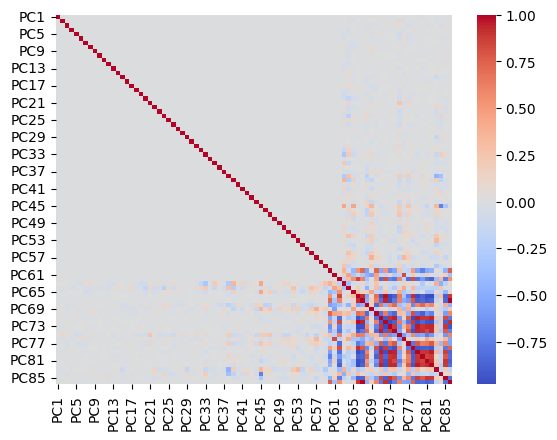

In [51]:
#Display correlations after PCA treatment 
sns.heatmap(X_proj.corr(),cmap='coolwarm')

In [52]:
#Observation: unlike expected, the correlations are not disappearing fully post PCA treatment. Let's investigate this later.

Text(0, 0.5, 'Variance')

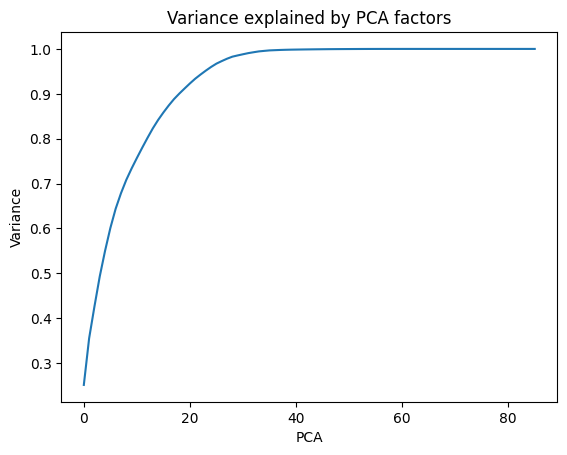

In [38]:
#For now let's focus on reducing dimensionality
pca.explained_variance_ratio_
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("Variance explained by PCA factors")
plt.xlabel('PCA')
plt.ylabel('Variance')

In [40]:
#Put the % of variance explained in a dataframe
percentage=[round(pca, 3) for pca in list(np.cumsum(pca.explained_variance_ratio_))]
percentage=[float(pca) for pca in percentage]
PCA_index=[i for i in range(1,87)]
summary=pd.DataFrame(percentage,PCA_index,columns=['% of cumulated variance explained'])
#Check how many PCA factors are requested to explain 95% of variance
summary[summary['% of cumulated variance explained']<0.951]

,% of cumulated variance explained
1,0.251
2,0.355
3,0.426
4,0.493
5,0.550
6,0.601
7,0.644
8,0.678
9,0.708
10,0.733


In [ ]:
#Conclusion: 2=with only 24 PCA factors, we would still explain 95% of our initial X variance

In [42]:
#Build a PCA model to reduce dimensionality from currently 95 to 24 features
pca_24=PCA(n_components=24)
#Fit and transform X and display it as a dataframe
pca_24.fit(X)
X_proj_24=pca_24.transform(X)
X_proj_24=pd.DataFrame(X_proj,columns=[f"PC{i}" for i in range(1,25)])

# 3.Run a logistic regression on X_proj_24

In [43]:
# Instantiate the base model
logistic_regression = LogisticRegression()

In [45]:
#Create train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X_proj_24,y,test_size=0.2,random_state=42)

In [46]:
# Train the model 
logistic_regression.fit(X_train, y_train)

LogisticRegression()

In [50]:
X_train.shape

(115374, 24)

In [47]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# Make predictions on the test set 
y_pred = logistic_regression.predict(X_test) 
# Evaluate the model accuracy
accuracy= accuracy_score(y_test, y_pred) 
conf_matrix = confusion_matrix(y_test, y_pred) 
class_report = classification_report(y_test, y_pred)

In [48]:
print(accuracy_score,conf_matrix,class_report)

<function accuracy_score at 0x7fc5a5038b80> [[20770   950]
 [ 5402  1722]]               precision    recall  f1-score   support

         0.0       0.79      0.96      0.87     21720
         1.0       0.64      0.24      0.35      7124

    accuracy                           0.78     28844
   macro avg       0.72      0.60      0.61     28844
weighted avg       0.76      0.78      0.74     28844



In [53]:
#Observation: the logistic regression recall drops massively from previously 56% to 25% when we add a PCA treatment to the preprocessing

<Axes: >

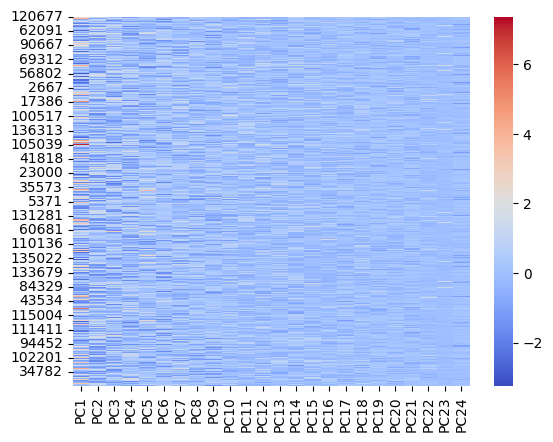

In [49]:
#Check correlation matrix of X_train
sns.heatmap(X_train, cmap='coolwarm')

# END OF THE NOTEBOOK